<a href="https://colab.research.google.com/github/FelixH-git/SVM-Pipeline/blob/main/lab5_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [2]:
X_train, X_test, y_train, y_test = X[:8000], X[8000:10100], y[:8000], y[8000:10100]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="linear"))
])

poly_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly"))
])

rbf_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf"))
])

In [4]:
from scipy.stats import uniform, randint

param_distribs_linear = {
    "svm_clf__C": uniform(0.1, 10)
}

param_distribs_poly = {
    "svm_clf__C": uniform(0.1, 20),
    "svm_clf__degree": randint(2, 5),
    "svm_clf__coef0": uniform(0, 2)
}

param_distribs_rbf = {
    "svm_clf__C": uniform(1, 20),
    "svm_clf__gamma": uniform(0.001, 0.1)
}

In [5]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score


scorers = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'accuracy': make_scorer(accuracy_score)
}


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import time

models = {
    "Linear SVM": (linear_svm_clf, param_distribs_linear),
    "Polynomial SVM": (poly_svm_clf, param_distribs_poly),
    "RBF SVM": (rbf_svm_clf, param_distribs_rbf)
}

results = {}

for name, (model, params) in models.items():
    rnd_search = RandomizedSearchCV(
        model, params, n_iter=5, cv=3,
        scoring='f1_macro', random_state=42, n_jobs=-1
    )

    start_time = time.time()
    rnd_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = rnd_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        "Best Params": rnd_search.best_params_,
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Accuracy": acc,
        "Training Time (s)": train_time
    }


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Use a pipeline with the same preprocessing as the SVMs
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Parameter distribution for randomized search (match SVM setup style)
param_distribs_knn = {
    'knn__n_neighbors': randint(1, 20),
    'knn__weights': ['uniform', 'distance']
}

rnd_knn = RandomizedSearchCV(
    knn_pipe, param_distribs_knn, n_iter=15, cv=3,
    scoring='f1_macro', random_state=42, n_jobs=-1
)

# Run randomized search and measure search time
start_search = time.time()
rnd_knn.fit(X_train, y_train)
train_time = time.time() - start_search


y_pred = rnd_knn.best_estimator_.predict(X_test)


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

results["KNN"] = {
    "Best Params": rnd_knn.best_params_,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "Accuracy": accuracy,
    "Training Time (s)": train_time
    }



In [14]:

from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform

sgd_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDClassifier(random_state=42))
])

param_distribs_sgd = {
    'sgd__alpha': uniform(1e-6, 1e-3),
    'sgd__max_iter': [1000],
}

rnd_sgd = RandomizedSearchCV(sgd_pipe, param_distribs_sgd, n_iter=15, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)

# Run randomized search and measure search time
start_search = time.time()
rnd_sgd.fit(X_train, y_train)
train_time = time.time() - start_search


y_pred = rnd_sgd.best_estimator_.predict(X_test)


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

results["SGD"] = {
    "Best Params": rnd_sgd.best_params_,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "Accuracy": accuracy,
    "Training Time (s)": train_time
}

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])

param_distribs_rf = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': randint(1, 50),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['sqrt', 'log2', None],
}

rnd_rf = RandomizedSearchCV(rf_pipe, param_distribs_rf, n_iter=15, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)

start_search = time.time()
rnd_rf.fit(X_train, y_train)
Train_time = time.time() - start_search

y_pred = rnd_rf.best_estimator_.predict(X_test)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

results["RandomForest"] = {
    "Best Params": rnd_rf.best_params_,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "Accuracy": accuracy,
    "Training Time (s)": train_time
}


wrong variable name for ("Training Time (s)": train_time)

In [22]:
results["RandomForest"] = {
    "Best Params": rnd_rf.best_params_,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "Accuracy": accuracy,
    "Training Time (s)": Train_time
}

In [23]:
results

{'Linear SVM': {'Best Params': {'svm_clf__C': np.float64(3.845401188473625)},
  'F1': 0.9039482172322417,
  'Precision': 0.905735750520129,
  'Recall': 0.9041587260054194,
  'Accuracy': 0.9061904761904762,
  'Training Time (s)': 106.8562376499176},
 'Polynomial SVM': {'Best Params': {'svm_clf__C': np.float64(3.219890406724053),
   'svm_clf__coef0': np.float64(0.11616722433639892),
   'svm_clf__degree': 2},
  'F1': 0.944919247296905,
  'Precision': 0.9451958589414076,
  'Recall': 0.9453208988797945,
  'Accuracy': 0.9457142857142857,
  'Training Time (s)': 118.71946287155151},
 'RBF SVM': {'Best Params': {'svm_clf__C': np.float64(4.12037280884873),
   'svm_clf__gamma': np.float64(0.016599452033620267)},
  'F1': 0.6558756138677236,
  'Precision': 0.886195321058528,
  'Recall': 0.5941824418242463,
  'Accuracy': 0.6,
  'Training Time (s)': 605.4474008083344},
 'KNN': {'Best Params': {'knn__n_neighbors': 6, 'knn__weights': 'distance'},
  'F1': 0.8930769016083492,
  'Precision': 0.89600479269

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results_df = pd.DataFrame(results).T
metrics_df = results_df[["Precision", "Recall", "F1", "Accuracy"]]
params_df = results_df[["Best Params"]]

print("Model Metrics:")
display(metrics_df)

for model in results:
    print(f"{model} training time: {results[model]['Training Time (s)']:.4f} s")

Model Metrics:


,Precision,Recall,F1,Accuracy
Linear SVM,0.905736,0.904159,0.903948,0.90619
Polynomial SVM,0.945196,0.945321,0.944919,0.945714
RBF SVM,0.886195,0.594182,0.655876,0.6
KNN,0.896005,0.893415,0.893077,0.894762
SGD,0.892595,0.89291,0.892359,0.894286
RandomForest,0.930196,0.930422,0.929605,0.930952


Linear SVM training time: 106.8562 s
Polynomial SVM training time: 118.7195 s
RBF SVM training time: 605.4474 s
KNN training time: 67.3674 s
SGD training time: 496.1595 s
RandomForest training time: 1070.5002 s


In [26]:
print("Best Hyperparameters:")
for model, row in params_df.iterrows():
    print(f"\n{model}:")
    for k, v in row["Best Params"].items():
        print(f"  {k}: {v}")




Best Hyperparameters:

Linear SVM:
  svm_clf__C: 3.845401188473625

Polynomial SVM:
  svm_clf__C: 3.219890406724053
  svm_clf__coef0: 0.11616722433639892
  svm_clf__degree: 2

RBF SVM:
  svm_clf__C: 4.12037280884873
  svm_clf__gamma: 0.016599452033620267

KNN:
  knn__n_neighbors: 6
  knn__weights: distance

SGD:
  sgd__alpha: 0.0007090725777960455
  sgd__max_iter: 1000

RandomForest:
  rf__max_depth: 39
  rf__max_features: sqrt
  rf__min_samples_leaf: 3
  rf__n_estimators: 156


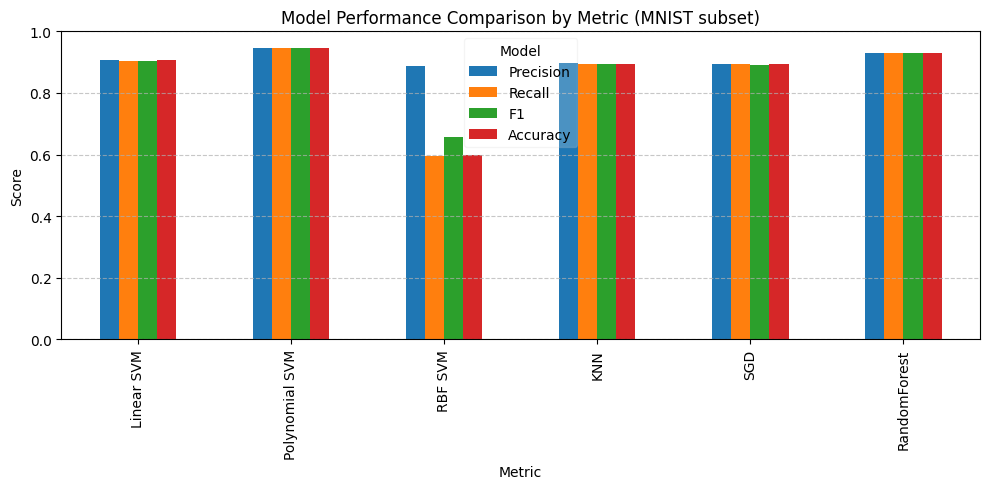

In [18]:
metrics_df = metrics_df.T

metrics_df.plot(
    kind='bar',
    figsize=(10, 5),
    title='Model Performance Comparison by Metric (MNIST subset)',
    stacked=False
)

plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model", framealpha=0.2)
plt.tight_layout()
plt.show()




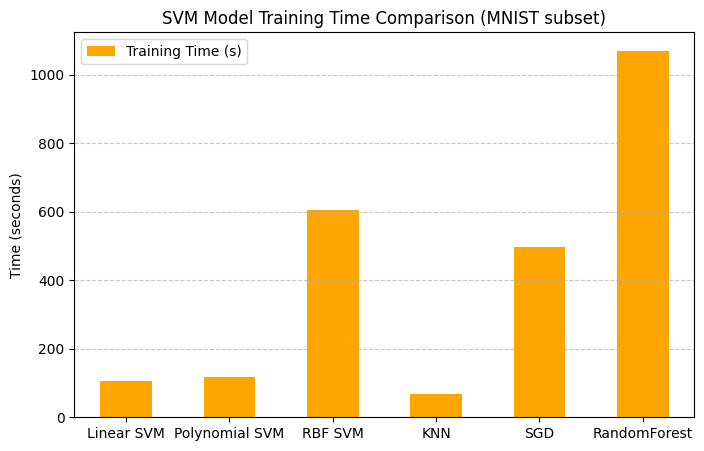

In [27]:
results_df[["Training Time (s)"]].plot(kind='bar', figsize=(8,5), color='orange')
plt.title("SVM Model Training Time Comparison (MNIST subset)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

